### Probabilistic model
Naive Bayes models the conditional probability of classes $C$, given an instance represented by a feature vector $x=(x_1, \dots, x_n)$, as 
\begin{align}
p(C_k \mid x) = \frac{p(x \mid C) p(C)}{p(x)}.
\end{align}
The most important assumption of the Naive Bayes model is that it assumes that all features are mutually independent conditional on the category $C$, e.g., 
\begin{align}
p(x_i \mid x_1, \dots, x_{i-1}, x_{i+1}, \dots, x_n, C) = p(x_i \mid C).
\end{align}

### Naive Bayes classifier
The Naive Bayes classifier is based on the MAP (maximum a posteriori) estimate of the conditional probability $p(C, x)$, i.e., given a feature vector $x$, we predict it being of the class
\begin{align}
\hat{y} = \text{argmax}_{k \in [K]} p(C) \prod_{i=1}^n p(x_i \mid C),
\end{align}
or equivalently (for computational reasons)
\begin{align}
\hat{y} = \text{argmax}_{k \in [K]} \left[ \log \left( p(C) \right) + \sum_{i=1}^n \log \left( p(x_i \mid C\right) \right].
\end{align}
For simplicity we assume here that $p(C=k) = c_k$ is constant. 

#### Modeling  the conditional probabilities
One can choose any model for the conditional probabilities $p(x_i \mid C)$, e.g., Gaussian, Bernoulli, multinomial, etc. Note that the Naive Bayes classifier can easily handle mixtures of categorical and real-valued features.

### Maximum likelihood training
Given a dataset $\left\{\left(X^{(j)}, Y^{(j)}\right)\right\}_{j \in [m]}$, we can train the parameters $\{ \theta_p \}_{p \in [P]}$ of our model (hidden in $p(x_i \mid C)$) using maximum likelihood, i.e., setting derivatives of the likelihood function $p(\theta | x, C)$ with respect to the $\theta_p$'s to zero and solving for the $\theta_p$'s. Using the independence assumption, we can find closed-form maximum likelihood estimates, e.g., if $p(x_i \mid C=k)$ is Gaussian, then 
\begin{align}
\mu_{ik} &= \sum_{Y_j = k \; \forall j \in [m]} \frac{X^{(j)}_i}{n_k}, \\
\sigma_{ik} &= \sum_{Y_j = k \; \forall j \in [m]} \frac{(X^{(j)}_i - \mu_{ik})^2}{n_k},
\end{align}
where $n_k$ is the amount of samples with class $k$ in the dataset.

### Sampling
Due to the independence assumption, sampling examples $\left(\hat{x}, \hat{C}\right) \sim p(x, C)$ is fairly easy. We first set $p(C=k) = n_k / m$ and sample $\hat{C} \sim p(C)$. Afterwards, we can sample the features $\hat{x}_i \sim p\left(x_i \mid C = \hat{C}\right)$. Sampling methods for easy probability distributions are implemented in NumPy.

In [1]:
import numpy as np

In [2]:
class NaiveBayes:
    def __init__(self, class_prior, features, n_classes):
        self.class_prior = class_prior
        self.features = features
        self.n_classes = n_classes
        
        self._init_weights()
        
    def _init_weights(self):
        self.weights = []
        
        for i, feature in enumerate(self.features):
            if feature == 'gaussian':
                self.weights.append((self._random_normal(), self._random_normal()))
            
            elif feature == 'bernoulli':
                self.weights.append((self._random_uniform()))
     
    def _random_normal(self, loc_in=0.0, scale_in=1.0, size_in=None):
        if size_in is None:
            size_in = self.n_classes
        
        return np.random.normal(loc=loc_in, scale=scale_in, size=size_in)
    
    def _random_uniform(self, low_in=0.0, high_in=1.0, size_in=None):
        if size_in is None:
            size_in = self.n_classes
        
        return np.random.uniform(low=low_in, high=high_in, size=size_in)
    
    def _random_bernoulli(p_in, n_in=1, size_in=1):
        return np.random.multionimal(n=n_in, pvals=p_in, size=size_in)
        
    def _conditional_log_probability(self, feature, class_index, feature_index):
        if self.features[feature_index] == 'gaussian':
            return - (1/2)*np.log(2*np.pi*self.weights[feature_index][1][class_index]**2) \
                   - (feature-self.weights[feature_index][0][class_index])**2 \
                   / (2*self.weights[feature_index][1][class_index]**2)
        
        elif self.features[feature_index] == 'bernoulli':
            if feature == 0:
                return np.log(1-self.weights[feature_index][class_index])
            else:
                return np.log(self.weights[feature_index][class_index])
    
    def log_likelihood(self, X, Y):
        log_likelihood = 0.0
        
        for x, y in zip(X, Y):
            sum_of_logs = 0.0
            for j, _ in enumerate(self.features):
                sum_of_logs += np.log(self.class_prior[y]) + self._conditional_log_probability(x[j], y, j)
                
            log_likelihood += sum_of_logs
            
        return log_likelihood
    
    def _gaussian_maximum_likelihood_fit(self, feature_number, X, Y):
        means = np.zeros((self.n_classes,))
        counts = np.zeros((self.n_classes,))
        
        for x, y in zip(X, Y):
            means[y] += x
            counts[y] += 1
                
        for i in range(self.n_classes):
             means[i] /= counts[i]
                
        variances = np.zeros((self.n_classes,))
        
        for x, y in zip(X, Y):
            variances[y] += (x - means[y])**2 / counts[y]
                
        for i in range(self.n_classes):
            self.weights[feature_number][0][i] = means[i]
            self.weights[feature_number][1][i] = np.sqrt(variances[i])
            
    def _bernoulli_maximum_likelihood_fit(self, feature_number, X, Y):
        means = np.zeros((self.n_classes,))
        counts = np.zeros((self.n_classes,))
        
        for x, y in zip(X, Y):
            means[y] += x
            counts[y] += 1
                
        for i in range(self.n_classes):
             means[i] /= counts[i]
                
        for i in range(self.n_classes):
            self.weights[feature_number][i] = means[i]
                
    def maximum_likelihood_fit(self, X, Y):
        for j, feature in enumerate(self.features):
            if feature == 'gaussian':
                self._gaussian_maximum_likelihood_fit(j, X[:, j], Y)
            elif feature == 'bernoulli':
                self._bernoulli_maximum_likelihood_fit(j, X[:, j], Y)
                
    def predictions(self, X):
        predictions = []
        
        for x in X:
            
            class_predictions = []
            for i in range(self.n_classes):
                
                class_predictions.append(self.log_likelihood([x], [i]))
                
            predictions.append(class_predictions)
            
        return predictions
    
    def sampling(self, n_samples):
        samples = np.empty((n_samples, len(self.features) + 1))
        for i in range(n_samples):
            features = []
            ### sample a class
            sampled_class = np.argwhere(np.random.multinomial(n=1, pvals=self.class_prior) == 1)
            samples[i, -1] = sampled_class
            
            for j, feature in enumerate(self.features):
                if feature == 'gaussian':
                    samples[i, j] = self._random_normal(loc_in = self.weights[j][0][sampled_class][0],
                                                        scale_in = self.weights[j][1][sampled_class][0],
                                                        size_in = 1)
                elif feature == 'bernoulli':
                    samples[i, j] = self._random_bernoulli(self.weights[j][samples_class][0])
                
        return samples

We will now fit a Naive Bayes classifier Iris flower data set and afterwards try to sample points 
from our generative model.

In [3]:
from sklearn.datasets import load_iris
from sklearn.utils import shuffle
from sklearn import preprocessing
from scipy.special import softmax
import matplotlib.pyplot as plt
%matplotlib inline

X, Y = load_iris(return_X_y=True)
X = preprocessing.scale(X) 
X, Y = shuffle(X, Y)

X_train = X[:100, :]
Y_train = Y[:100]

X_test = X[100:, :]
Y_test = Y[100:]

### Maximum likelihood fitting 
naive_bayes_iris = NaiveBayes([1/3.]*3, ['gaussian']*4, 3)

print('Log-likelihood before fitting (random weights):', naive_bayes_iris.log_likelihood(X_train, Y_train))

naive_bayes_iris.maximum_likelihood_fit(X_train, Y_train)

print('Log-likelihood after fitting:', naive_bayes_iris.log_likelihood(X_train, Y_train))

Log-likelihood before fitting (random weights): -1584.5829832421746
Log-likelihood after fitting: -627.6014130704741


In [4]:
predictions = naive_bayes_iris.predictions(X_test)
print('Accuracy on test set:', np.sum(np.argmax(predictions, axis=1) == Y_test) / 50)

Accuracy on test set: 0.96


In [5]:
### Sampling points 
samples = naive_bayes_iris.sampling(50)

In the next plots we compare the data distribution to the sampling distribution. We can clearly see that the features (conditioned on the class) of the data distribution are correlated, and therefore the naive Bayes model might not be perfect for this case. 

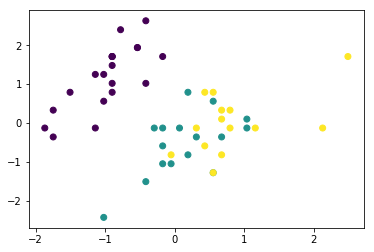

In [6]:
### Data distribution for feature 1 and 2
plt.scatter(X_test[:, 0], X_test[:, 1], c=Y_test)

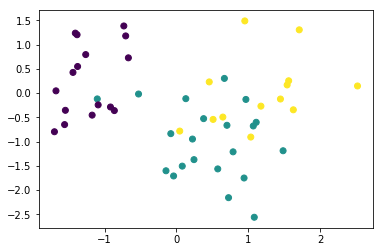

In [7]:
### Sampling distribution for feature 1 and 2
plt.scatter(samples[:, 0], samples[:, 1], c=samples[:, 4])

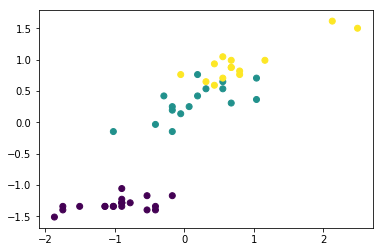

In [8]:
### Data distribution for feature 1 and 3
plt.scatter(X_test[:, 0], X_test[:, 2], c=Y_test)

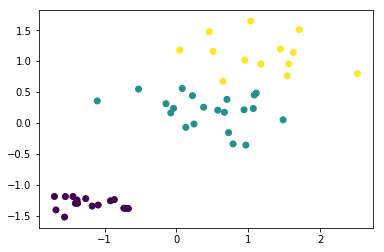

In [9]:
### Sampling distribution for feature 1 and 3
plt.scatter(samples[:, 0], samples[:, 2], c=samples[:, 4])